In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


In [2]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

/home/aiden/miniconda3/envs/homeworkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.1.1+cu121; Torch-cuda version: 12.1; Torch Geometric version: 2.4.0.


In [3]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = './Software_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "./meta_Software.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [5]:
categories_names = []
for line in file_metadata:
    for cat in line['category']:
        if cat not in categories_names:
            categories_names.append(cat)
        

In [6]:
categories_names

['Software',
 'Education &amp; Reference',
 'Languages',
 'Education & Reference',
 'Test Preparation',
 'Business &amp; Office',
 'Business &amp; Marketing Plans',
 'Design &amp; Illustration',
 'CAD',
 'Programming & Web Development',
 'Web Design',
 'Dictionaries',
 'Religion',
 'Training',
 'Photography',
 'Programming &amp; Web Development',
 'Web Page Editors',
 "Children's",
 'Math',
 'Science &amp; Nature',
 'Games',
 'Early Learning',
 'Typing',
 'Office Suites',
 'Programming Languages',
 '</span></span></span>',
 'Science',
 'This builds phonological awareness and auditory processing skills.',
 'Six fun interactive games with 309 levels deliver extensive training and practice.',
 'The software automatically adjusts to the appropriate skill level of the user.',
 'Earobics uses adaptive training and acoustically modified speech.',
 'Recommended for ages 4 to 7.',
 'Earobics Step 2 features five interactive games with 593 levels.',
 'Recommended for ages 7 to 11;Operating Syste

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories_names)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

def vec_to_category(vector) -> str:
    return label_encoder.inverse_transform([np.argmax(vector)])[0]

def categories_to_vec(categories):
    categories = list(set(categories))
    integer_encoded = label_encoder.transform(categories)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    # print(onehot_encoded)
    output = onehot_encoded[0]
    for i in range(1, len(onehot_encoded)):
        output += onehot_encoded[i]
    return output



/home/aiden/miniconda3/envs/homeworkenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
review_df = pd.DataFrame(review_data,columns=['reviewerID','asin','overall'])
review_df.head()

,reviewerID,asin,overall
0,A38NELQT98S4H8,0321719816,4.0
1,A3QJU4FEN8PQSZ,0321719816,4.0
2,ACJT8MUC0LRF0,0321719816,5.0
3,AYUF7YETYOLNX,0321719816,5.0
4,A31ICLWQ9CSHRS,0321719816,5.0


In [9]:
from sentence_transformers import SentenceTransformer

class TextEncoder:
    """
    A class for encoding text using a SentenceTransformer model.
    """
    def __init__(self, model='all-MiniLM-L6-v2', device=None):
        """
        :param model: Name of the SentenceTransformer model to use.
        :param device: Device to use for model inference. Default is None.
        """
        self.device = device
        self.model = SentenceTransformer(model, device=self.device)

    @torch.no_grad()
    def __call__(self, values: list):
        """
        Encode a list of text values into embeddings.

        :param values: List of text values to encode.
        :return: Encoded embeddings as a PyTorch tensor.
        """
        x = self.model.encode(values,
                              show_progress_bar=True,
                              convert_to_tensor=True,
                              device=self.device)
        return x.cpu()


# Check if CUDA is available, and set the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Create an instance of the TextEncoder class with the determined device
encoder = TextEncoder(device=device)

2023-12-07 09:46:39.703823: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 09:46:39.828192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 09:46:40.383306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
metadata_df = pd.DataFrame(file_metadata,columns=['asin','category','title','description','also_buy'])
print(metadata_df.head())
len(metadata_df)

         asin category                                              title  \
0  0030672120       []  HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...   
1  0071480935       []  Sing, Watch, &amp; Learn Spanish (DVD + Guide)...   
2  007329506X       []  Connect with LearnSmart Access Card for Microb...   
3  0073513458       []  LearnSmart Standalone Access Card for Prescott...   
4  0073525758       []  Anatomy &amp; Physiology Revealed Student Acce...   

                                         description  \
0                                                 []   
1  [, <b>Latin rhythms that will get your kids si...   
2  [<b>Connect is the only integrated learning sy...   
3                                                 []   
4  [<i>Anatomy &amp; Physiology Revealed Cat</i> ...   

                               also_buy  
0                                    []  
1                                    []  
2                                    []  
3                               

26790

In [13]:
del review_data
del file_metadata

In [14]:
unique_user_id = review_df['reviewerID'].unique()
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = metadata_df['asin'].unique()
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

In [15]:
def one_hot(x):
    if len(x) == 0 :
        return np.zeros(shape=(len(onehot_encoded)))
    else:
        return categories_to_vec(x)

In [16]:
metadata_df["category"] = metadata_df["category"].apply(lambda x: one_hot(x))

In [17]:
product_features = torch.zeros(len(unique_product_id), 384 + len(onehot_encoded))
def convert_to_embed(x):
    product = x["asin"]
    mapped_id = unique_product_id.loc[unique_product_id['productId'] == product, 'mappedID'].values[0]
    one_hot =  torch.tensor(x["category"])
    d = ' '.join(x["description"])
    if d == "":
        product_features[mapped_id] = torch.cat((encoder("None"), one_hot), -1)
    else:
        product_features[mapped_id] = torch.cat((encoder(d), one_hot), -1)

In [18]:
metadata_df.apply(lambda x : convert_to_embed(x),axis=1)
print(product_features.shape)

Batches: 100%|██████████| 1/1 [00:00<00:00, 397.94it/s]


torch.Size([21639, 7340])


In [19]:
product_product_edges = []
for product_id in metadata_df["asin"].unique():
   product = metadata_df[metadata_df["asin"] == product_id].iloc[0]
   if len(product["also_buy"]) == 0 :
       continue
   for also_bought_product in product["also_buy"]:
       if (unique_product_id['productId'] == also_bought_product).any():
           product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product_id, 'mappedID'].values[0],
                                     unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
product_product_edges = torch.t(torch.tensor(product_product_edges, dtype=torch.long))
print(product_product_edges.shape)


torch.Size([2, 7253])


In [20]:
user_product_edges = []
user_product_ratings = []
for review in review_df.itertuples():
   user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == review.reviewerID, 'mappedID'].values[0],
                              unique_product_id.loc[unique_product_id['productId'] == review.asin, 'mappedID'].values[0]])
   user_product_ratings.append(review.overall)
user_product_edges = torch.t(torch.tensor(user_product_edges, dtype=torch.long))
user_product_ratings = torch.tensor(user_product_ratings, dtype=torch.float) 
print(user_product_edges.shape)

torch.Size([2, 12805])


In [21]:
from torch_geometric.data import HeteroData
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
# data['User'].x = torch.ones(len(users), 1)
data['User'].x = torch.eye(len(review_df['reviewerID'].unique()))

# Add edge indices to the HeteroData object
data['User', 'REVIEWS', 'Product'].edge_index = user_product_edges
data['User', 'REVIEWS', 'Product'].edge_label = user_product_ratings
data['Product', 'ALSO_BOUGHT', 'Product'].edge_index = product_product_edges

import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['Product', 'rev_REVIEWS', 'User'].edge_label


In [22]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('User', 'REVIEWS', 'Product'), ('Product', 'ALSO_BOUGHT', 'Product')],
    rev_edge_types=[('Product', 'rev_REVIEWS', 'User'),('Product', 'rev_ALSO_BOUGHT', 'Product')],
)(data)
train_data, val_data

# train_data, val_data, test_data = T.RandomLinkSplit(
#     num_val=0.1,
#     num_test=0.1,
#     neg_sampling_ratio=0.0,
#     edge_types=[('User', 'REVIEWS', 'Product')],
#     rev_edge_types=[('Product', 'rev_REVIEWS', 'User')],
# )(data)
train_data, val_data

(HeteroData(
   Product={ x=[21639, 7340] },
   User={ x=[1826, 1826] },
   (User, REVIEWS, Product)={
     edge_index=[2, 10245],
     edge_label=[10245],
     edge_label_index=[2, 10245],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8588],
     edge_label=[8588],
     edge_label_index=[2, 8588],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 10245] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ),
 HeteroData(
   Product={ x=[21639, 7340] },
   User={ x=[1826, 1826] },
   (User, REVIEWS, Product)={
     edge_index=[2, 10245],
     edge_label=[1280],
     edge_label_index=[2, 1280],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8588],
     edge_label=[1073],
     edge_label_index=[2, 1073],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 10245] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ))

In [23]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [24]:
train_data.edge_index_dict

{('User',
  'REVIEWS',
  'Product'): tensor([[   71,   554,  1384,  ...,  1154,   999,  1065],
         [19236,  8514, 14400,  ..., 21625, 18980, 17762]]),
 ('Product',
  'ALSO_BOUGHT',
  'Product'): tensor([[ 1163, 21400,  3257,  ...,  3844, 20631,   889],
         [ 1887, 20153, 10947,  ...,  3779, 19496,  6008]]),
 ('Product',
  'rev_REVIEWS',
  'User'): tensor([[19236,  8514, 14400,  ..., 21625, 18980, 17762],
         [   71,   554,  1384,  ...,  1154,   999,  1065]])}

In [29]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 130
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 0.6860, Train: 0.8820, Val: 1.0718
Epoch: 002, Loss: 0.9485, Train: 1.4241, Val: 1.5205
Epoch: 003, Loss: 2.0281, Train: 1.0777, Val: 1.2232
Epoch: 004, Loss: 1.1615, Train: 0.8472, Val: 1.0429
Epoch: 005, Loss: 0.7859, Train: 1.0084, Val: 1.1558
Epoch: 006, Loss: 1.4485, Train: 0.8798, Val: 1.0623
Epoch: 007, Loss: 0.8834, Train: 0.8539, Val: 1.0382
Epoch: 008, Loss: 0.7310, Train: 1.0157, Val: 1.1608
Epoch: 009, Loss: 1.0316, Train: 1.0461, Val: 1.1836
Epoch: 010, Loss: 1.0943, Train: 0.9296, Val: 1.0900
Epoch: 011, Loss: 0.8642, Train: 0.8303, Val: 1.0155
Epoch: 012, Loss: 0.6957, Train: 0.8683, Val: 1.0474
Epoch: 013, Loss: 0.8305, Train: 0.9044, Val: 1.0742
Epoch: 014, Loss: 0.9552, Train: 0.8614, Val: 1.0416
Epoch: 015, Loss: 0.8088, Train: 0.8269, Val: 1.0122
Epoch: 016, Loss: 0.6918, Train: 0.8721, Val: 1.0445
Epoch: 017, Loss: 0.7611, Train: 0.9206, Val: 1.0816
Epoch: 018, Loss: 0.8476, Train: 0.9020, Val: 1.0673
Epoch: 019, Loss: 0.8138, Train: 0.8448, Val: 

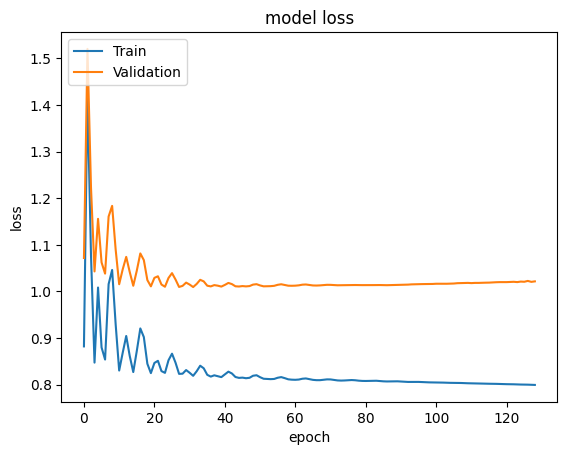

In [30]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [31]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 1.1206
      userId  ProdId    rating  target
0        463   15504  3.275608     5.0
1       1046   11721  4.676224     5.0
2        101   15291  2.390568     3.0
3       1785   14397  3.790672     5.0
4       1616   21031  4.497290     2.0
...      ...     ...       ...     ...
1275     481    7007  5.000000     5.0
1276     608   10355  3.654054     2.0
1277      69   18939  2.886563     1.0
1278    1061   15149  3.380078     2.0
1279     657   11654  3.545431     5.0

[1280 rows x 4 columns]


In [32]:
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [33]:
from torch_geometric.nn import GATConv, GCNConv


In [34]:

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels,heads = 2, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels,heads = 1, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=2)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=2)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=2)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=1)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=1)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=1)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [37]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 150
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 1.0427, Train: 1.5415, Val: 1.5698
Epoch: 002, Loss: 6.1654, Train: 1.0360, Val: 1.1348
Epoch: 003, Loss: 1.0864, Train: 1.5450, Val: 1.5841
Epoch: 004, Loss: 2.3870, Train: 1.9127, Val: 1.9294
Epoch: 005, Loss: 3.6586, Train: 1.9276, Val: 1.9456
Epoch: 006, Loss: 3.7157, Train: 1.7399, Val: 1.7696
Epoch: 007, Loss: 3.0272, Train: 1.4460, Val: 1.4954
Epoch: 008, Loss: 2.0911, Train: 1.1653, Val: 1.2402
Epoch: 009, Loss: 1.3579, Train: 1.0934, Val: 1.1798
Epoch: 010, Loss: 1.1999, Train: 1.2348, Val: 1.3051
Epoch: 011, Loss: 1.6326, Train: 1.3322, Val: 1.3918
Epoch: 012, Loss: 2.0617, Train: 1.3140, Val: 1.3749
Epoch: 013, Loss: 1.9739, Train: 1.2085, Val: 1.2809
Epoch: 014, Loss: 1.5426, Train: 1.0960, Val: 1.1830
Epoch: 015, Loss: 1.2097, Train: 1.0812, Val: 1.1706
Epoch: 016, Loss: 1.1693, Train: 1.1519, Val: 1.2346
Epoch: 017, Loss: 1.3269, Train: 1.2231, Val: 1.2975
Epoch: 018, Loss: 1.4961, Train: 1.2472, Val: 1.3169
Epoch: 019, Loss: 1.5555, Train: 1.2182, Val: 

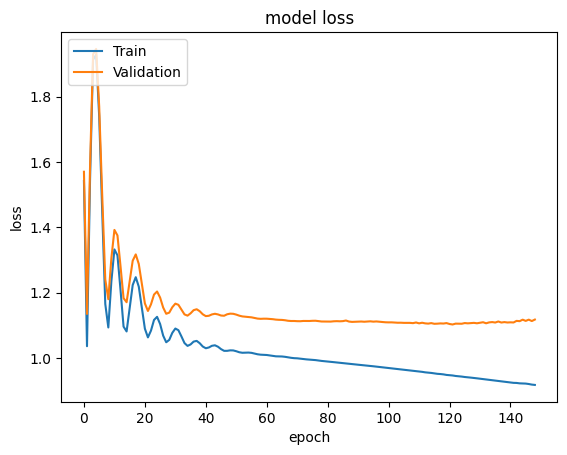

In [38]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [39]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 1.3079
      userId  ProdId    rating  target
0        463   15504  2.802910     5.0
1       1046   11721  4.014022     5.0
2        101   15291  3.652023     3.0
3       1785   14397  4.703082     5.0
4       1616   21031  4.055345     2.0
...      ...     ...       ...     ...
1275     481    7007  3.969085     5.0
1276     608   10355  4.882874     2.0
1277      69   18939  3.423512     1.0
1278    1061   15149  3.746828     2.0
1279     657   11654  3.225064     5.0

[1280 rows x 4 columns]


In [69]:
max_reviews_reviewer = review_df.groupby('reviewerID').size().idxmax()
random_user = review_df['reviewerID'].sample(1).values[0]


In [70]:
random_user

'A19QMWXXUUTA9I'

In [73]:
mapped_user_id = unique_user_id.loc[unique_user_id['userId'] == random_user, 'mappedID'].values[0]
print(mapped_user_id)
products_rated = review_df[review_df['reviewerID'] == random_user]
products_not_rated = metadata_df[~metadata_df.asin.isin(products_rated['asin'])]
products_not_rated = products_not_rated.merge(unique_product_id, left_on='asin', right_on='productId', how='inner')
product = products_not_rated.sample(1)

1544


In [74]:
product_id_mapped = product["mappedID"].item()

In [75]:
edge_label_index = torch.tensor([
    mapped_user_id,
    product_id_mapped])


with torch.no_grad():
    test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict, edge_label_index)
    pred = pred.clamp(min=0, max=5).detach().cpu().numpy()
print(pred.item())

1.5213778018951416


In [76]:
from torch_geometric.explain import Explainer, CaptumExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type=None,
    edge_mask_type='object',
)

explanation = explainer(
    test_data.x_dict, test_data.edge_index_dict, index=0,
    edge_label_index=edge_label_index).cpu().detach()
explanation

HeteroExplanation(
  prediction=[1],
  target=[1],
  index=[1],
  edge_label_index=[2],
  Product={ x=[21639, 7340] },
  User={ x=[1826, 1826] },
  (User, REVIEWS, Product)={
    edge_mask=[11525],
    edge_index=[2, 11525],
  },
  (Product, ALSO_BOUGHT, Product)={
    edge_mask=[9661],
    edge_index=[2, 9661],
  },
  (Product, rev_REVIEWS, User)={
    edge_mask=[11525],
    edge_index=[2, 11525],
  }
)

In [77]:
prod_id = unique_product_id.loc[unique_product_id['mappedID'] == product_id_mapped, 'productId'].values[0]
title = metadata_df.loc[metadata_df["asin"] == prod_id,"title"].values[0]
user_to_product = explanation['User', 'Product'].edge_index.numpy().T
user_to_product_attr = explanation['User', 'Product'].edge_mask.numpy().T
user_to_product_df = pd.DataFrame(
    np.hstack([user_to_product, user_to_product_attr.reshape(-1,1)]),
    columns = ['mappedUserId', 'mappedProductId', 'attr']
)

product_to_user = explanation['Product', 'User'].edge_index.numpy().T
product_to_user_attr = explanation[ 'Product', 'User'].edge_mask.numpy().T
product_to_user_df = pd.DataFrame(
    np.hstack([product_to_user, product_to_user_attr.reshape(-1,1)]),
    columns = ['mappedProductId', 'mappedUserId','attr']
)
explanation_df = pd.concat([user_to_product_df, product_to_user_df])
explanation_df[["mappedUserId", "mappedProductId"]] = explanation_df[["mappedUserId", "mappedProductId"]].astype(int)

print(f"Attribtion for all edges towards prediction of Product rating of Product:\n {title}")
print("==========================================================================================")
print(explanation_df.sort_values(by='attr'))

Attribtion for all edges towards prediction of Product rating of Product:
 Dragon NaturallySpeaking 13 Training Video: Fundamentals for Home and Small Business
       mappedUserId  mappedProductId         attr
6655            470            18977 -0.134220494
10303          1666            16677 -0.008189992
2633            562            18727 -0.007082457
8150           1250            18725 -0.003626966
214            1429            18727 -0.001419791
...             ...              ...          ...
10563          1201            18725  0.012508203
8828           1663            16677  0.026346029
5377           1587            16677  0.027256812
8736           1544            16677  0.119639463
3476           1544            18977  0.156831523

[23050 rows x 3 columns]


In [56]:
print(prod_id)
metadata_df.loc[metadata_df["asin"] == "B000JMFKQI"]

B000JMFKQI


,asin,category,title,description,also_buy
14230,B000JMFKQI,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Type to Learn 3 Single Edit,[],[]


In [78]:
explanation_df = explanation_df[explanation_df['mappedUserId'] == mapped_user_id]
print(explanation_df)
explanation_df = explanation_df.groupby('mappedProductId').sum()
explanation_df = explanation_df.merge(unique_product_id, left_on='mappedProductId', right_on='mappedID', how='inner')
explanation_df = explanation_df.merge(metadata_df, left_on='productId', right_on='asin', how='inner')
pd.options.display.float_format = "{:,.9f}".format

print("Top products that influenced the prediction:")
print("==============================================")
print(explanation_df.sort_values(by='attr', ascending=False, key= lambda x: abs(x))[['title', 'attr']].head())

       mappedUserId  mappedProductId         attr
1235           1544            20902  0.000000930
3099           1544            15406  0.000000020
3476           1544            18977 -0.000115013
6012           1544            15567  0.000000020
8362           1544            17052  0.000000034
8736           1544            16677 -0.000013601
11045          1544            17259 -0.000002220
1235           1544            20902  0.000021141
3099           1544            15406 -0.000065970
3476           1544            18977  0.156831523
6012           1544            15567  0.000017805
8362           1544            17052 -0.000010233
8736           1544            16677  0.119639463
11045          1544            17259  0.000359584
Top products that influenced the prediction:
                                               title         attr
5  TurboTax Home &amp; Business 2014 Fed + State ...  0.156716510
2                       Amazon Music [PC] [Download]  0.119625862
4  Turb